<a href="https://colab.research.google.com/github/edwinyung/AWS_ECS_clone/blob/master/TF_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tf-nightly

     |████████████████████████████████| 325.9MB 51kB/s 
     |████████████████████████████████| 460kB 36.2MB/s 
     |████████████████████████████████| 9.5MB 42.5MB/s 


In [ ]:
!pip install tf-models-official -q

     |████████████████████████████████| 849kB 2.8MB/s 
     |████████████████████████████████| 102kB 7.2MB/s 
     |████████████████████████████████| 358kB 14.8MB/s 
     |████████████████████████████████| 36.6MB 107kB/s 
     |████████████████████████████████| 1.1MB 40.1MB/s 
     |████████████████████████████████| 174kB 45.8MB/s 


In [ ]:
import tensorflow as tf
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [ ]:
import tensorflow_hub as hub
hub_encoder = hub.KerasLayer(hub_url_bert, trainable=True)

In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)


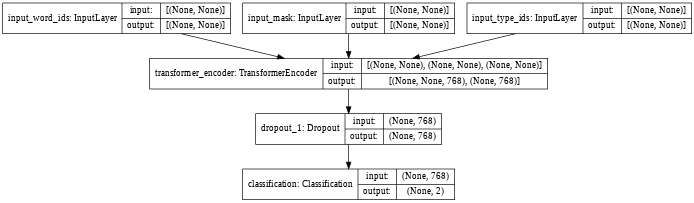

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

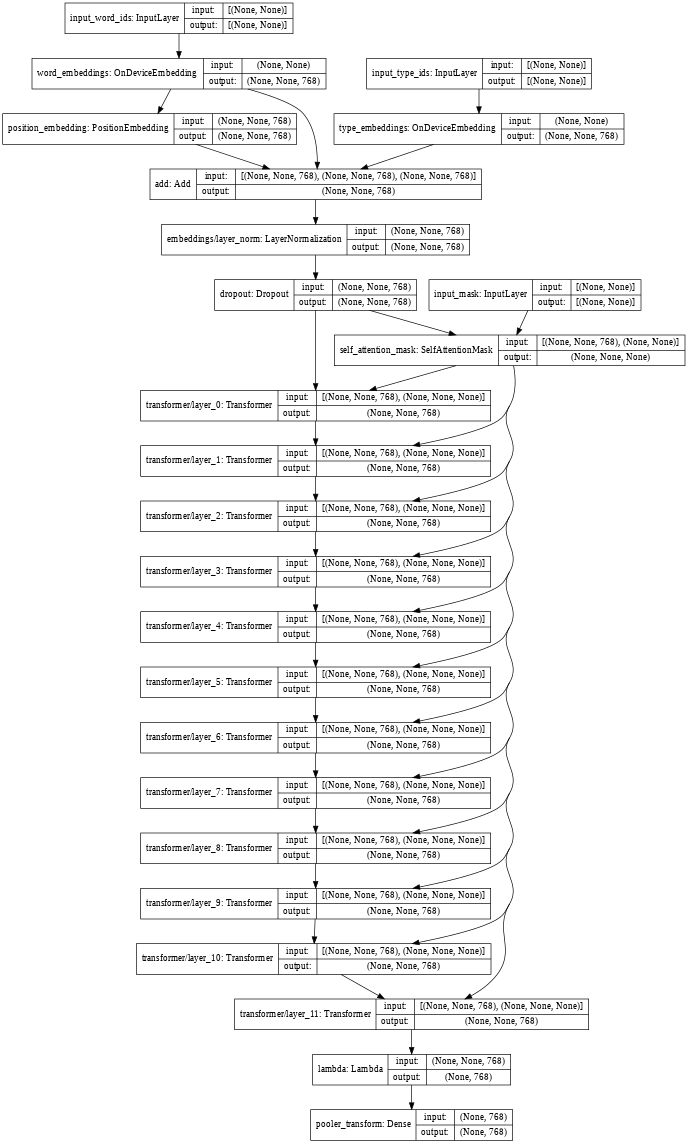

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
bert_encoder.get_layer(index=-1)

In [ ]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteF3YBAX/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteF3YBAX/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteF3YBAX/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [ ]:
glue_train  = glue['train']
glue_train

{'idx': <tf.Tensor: shape=(3668,), dtype=int32, numpy=array([1680, 1456, 3017, ..., 3682, 3619, 3624], dtype=int32)>,
 'label': <tf.Tensor: shape=(3668,), dtype=int64, numpy=array([0, 0, 1, ..., 1, 0, 1])>,
 'sentence1': <tf.Tensor: shape=(3668,), dtype=string, numpy=
 array([b'The identical rovers will act as robotic geologists , searching for evidence of past water .',
        b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed .",
        b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .',
        ...,
        b'Stack said he did no work for Triumph until 1999 , when a grand jury began investigating Silvester .',
        b'The giant rock was first observed on August 24 by Lincoln Near-Earth Asteroid Research Program , based in Socorro , New Mexico .',
        b"Two of Collins ' top assistants will consult with state police during the investigation and determine 

In [ ]:
sentence1

<tf.RaggedTensor [[1996, 7235, 9819, 2097, 2552, 2004, 20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102]]>

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_train["sentence1"])[:1]])

input_word_ids = tf.concat([sentence1], axis=-1)

input_mask = tf.ones_like(input_word_ids).to_tensor()


type_s1 = tf.zeros_like(sentence1)
input_type_ids = tf.concat(
    [type_s1], axis=-1).to_tensor()

inputs = {
    'input_word_ids': input_word_ids.to_tensor(),
    'input_mask': input_mask,a
    'input_type_ids': input_type_ids}
inputs

SyntaxError: ignored

In [ ]:
bert_encoder.predict(inputs)

(1, 1, 768)

In [ ]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

Vocab size: 30522
['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [ ]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

In [ ]:
list(glue.keys())

['test', 'train', 'validation']

In [ ]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})